# Реализация алгоритма модели нейронной сети

### Сделаем импорт основных библиотек

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(45)

### Создаем искусственный набор данных

In [3]:
# Y, X1, X2, X3
data = np.array([
    [0.0, 1.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 1.0, 1.0, 0.0],
    [0.0, 0.0, 1.0, 1.0],
    [0.0, 0.98, 0.98, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.01, 0.98, 0.09],
    [0.0, 0.98, 0.98, 0.1],
    [0.0, 0.02, 0.98, 0.98],    
    [1.0, 0.0, 0.0, 1.0],
    [1.0, 1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0, 1.0],
    [1.0, 1.0, 1.0, 1.0],    
    [1.0, 0.01, 0.02, 0.98],
    [1.0, 0.98, 0.03, 0.0],
    [1.0, 0.98, 0.04, 0.98],
    [1.0, 0.99, 0.95, 0.98],
])  
 


Визуализируем данные с помощью pca (метод главных компонент)

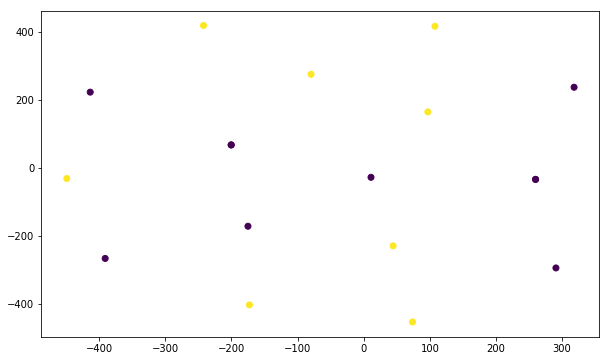

In [4]:
# Show data
from sklearn import manifold

tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_2d_tsne = tsne.fit_transform(data[:,1:]) 

plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:, 0], data_2d_tsne[:, 1], c = data[:,0])

Создаем простую модель нейронной сети - классификатора

Функция активации

$$ \dfrac{1}{1+e^{-x}}$$


Функция ошибки MSE

$$ - \dfrac{1}{N} \sum{(t_i-p_i)^2} $$

Функция ошибки BCE

$$ - \dfrac{1}{N} \sum{ t_i \dot log (p_i) + (1-t_i) \dot log(1 - p_i)} $$

In [5]:

class Model:
    ''' NN model '''
    
    def __init__(self, learning_rate = 0.05, innput_size = 3, hidden_size = 2):
            self.learning_rate = learning_rate
            self.innput_size = innput_size
            
            self.WH1 = np.random.rand(hidden_size,innput_size)
            self.WH2 = np.random.rand(1,hidden_size)
            self.O1 = np.array([])
            self.O2 = np.array([])
            #print(self.WH1)
            #print(self.WH2)
        
    ''' Predict model '''    
    def predict(self, inputs):
        self.O1 = self.WH1.dot(inputs)
        self.O1 = self.sigmoid(self.O1)
        self.O2 = self.WH2.dot(self.O1)
        self.O2 = self.sigmoid(self.O2) 
        return self.O2
    
    ''' Train model '''
    def train(self, inputs, actual):
        out = self.predict(inputs)
        outputs_2 = out[0]
        # получаем ошибку
        error_2 = outputs_2 - actual 
        # получаем градиент 2 слоя т.к. значение функции равно ее производной, нам ненужно делать вычисления
        gradient_layer_2 = outputs_2 * (1 - outputs_2) # dx
        # получаем вклад в общую ошибку 2 слоя (через градиент)
        weights_delta_layer_2 = error_2 * gradient_layer_2        
        # вычитаем ошибку из второго (скрытого) слоя, с штрафом learning_rate
        self.WH2 -=  self.O1.dot(weights_delta_layer_2 * self.learning_rate)
        error_layer_1 = weights_delta_layer_2 *  self.WH2
        
        # получаем градиент 1 слоя
        gradient_layer_1 = self.O1 * (1 -  self.O1) # dx
        # получаем вклад в общую ошибку 1 слоя (через градиент)
        weights_delta_layer_1 =  error_layer_1 * gradient_layer_1 
        # вычитаем ошибку из входного слоя, с штрафом learning_rate
        ne = inputs.reshape(self.innput_size,1).dot(weights_delta_layer_1   * self.learning_rate) 
        self.WH1 -= ne.T
            
    
    ''' Function sigmoid '''
    def sigmoid(self, x):
        return 1. / (1. + np.exp( -x ))
        
            

### Создаем модель нейронной сети для работы с искусственным набором данных

In [6]:
model = Model(hidden_size=2) 

accuracy_rate = 0.05 # 5%
errors = []
accuracy = []

In [10]:
n_epoch = 2000 

while(n_epoch > 0):
    
    for item in data:  
        model.train(item[1:], item[0]) 
    
    n_epoch = n_epoch - 1
    
    s = 0.0   
    poz = 0.0
    for item in data: 
        p = model.predict(item[1:])     
        t = item[0]
        # s = s + (item[0] - p) ** 2 # mse 
        s = s + (t * np.log(p) + (1-t) *np.log(1-p) ) # bce
        
        #s = s + (1. / (1 + np.exp(- (item[0] - p))))
        if(np.absolute(p - item[0]) < accuracy_rate):
            poz = poz + 1
    accuracy.append(poz / len(data))    
    errors.append( - s / len(data) )    
 

Выводим график обучения сети

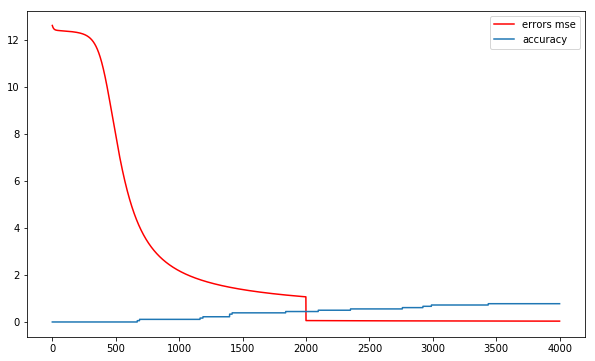

In [13]:

plt.figure(figsize = (10, 6))
plt.plot(errors, label='errors mse', color = 'red')
plt.plot(accuracy, label='accuracy')
plt.legend()
plt.show()

In [14]:
print("Error: %.4f, Accuracy: %.4f" % (min(errors), max(accuracy)))


Error: 0.0359, Accuracy: 0.7778


In [15]:
for item in data: 
    p = model.predict(item[1:])     
    print("Predict: %.2f, Actual: %.2f" % (p, item[0]))

Predict: 0.02, Actual: 0.00
Predict: 0.09, Actual: 0.00
Predict: 0.00, Actual: 0.00
Predict: 0.02, Actual: 0.00
Predict: 0.02, Actual: 0.00
Predict: 0.02, Actual: 0.00
Predict: 0.09, Actual: 0.00
Predict: 0.00, Actual: 0.00
Predict: 0.03, Actual: 0.00
Predict: 0.03, Actual: 0.00
Predict: 0.96, Actual: 1.00
Predict: 0.96, Actual: 1.00
Predict: 0.98, Actual: 1.00
Predict: 0.94, Actual: 1.00
Predict: 0.96, Actual: 1.00
Predict: 0.95, Actual: 1.00
Predict: 0.98, Actual: 1.00
Predict: 0.95, Actual: 1.00


### Создаем модель классификатор спама

Сначала загружаем набор данных SMSSpamCollection

In [16]:
import pandas as pd

file_data = './data_sets/SMSSpamCollection.csv'

df = pd.read_csv(file_data, names=['class','text'])
print(df.head(3))
print(df.info())
print(df.sample(3))

  class                                               text
0  ham    Go until jurong point  crazy Available only i...
1  ham                             Ok lar Joking wif u oni
2  spam    Free entry in 2 a wkly comp to win FA Cup fi...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
class    5574 non-null object
text     5574 non-null object
dtypes: object(2)
memory usage: 87.2+ KB
None
     class                                               text
1153  ham                                 Ok i go change also
2993  ham                   Ki didt see youkwhere are you now
2695  ham    Hey sexy buns What of that day No word from y...


Добавим метку с классом target и построим гистограмму распределения класса.

        class  text
target             
0        4827  4827
1         747   747


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f579821e9b0>],
      dtype=object)

<Figure size 720x432 with 0 Axes>

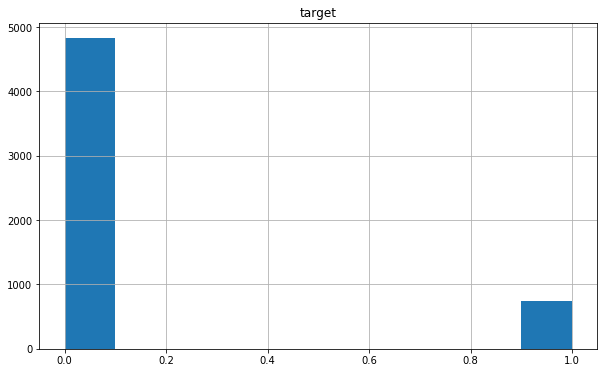

In [17]:
def t(x): 
    if(x == 'spam'):
        return 1
    return 0

df['target'] = df['class'].map(t)
print(df.groupby('target').count())

# plt.
plt.figure(figsize = (10, 6))
fig = plt.figure(figsize = (10,6))
ax = fig.gca() 
df.hist('target', ax = ax)

### Подготовим текст

Разобьем выборку на тренировочную и обучающую часть ~ 67 / 33 %

Проведем векторизацию текста слов (построим для каждого примера частотное распределение в общем словаре)

Зазадим максимальный корпус слов 5000

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer


text_train, text_test, y_train, y_test = train_test_split(df['text'], df['target'].as_matrix(), test_size=0.33, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000, token_pattern='[a-zA-Z]+', stop_words=['and', 'a', 'the', 'they', 'on', 'or', 'if', 'else', 'then']) 
X_train = vectorizer.fit_transform(text_train).toarray()
X_test = vectorizer.transform(text_test).toarray()
#print(vectorizer.get_feature_names()) 
print(X_train.shape)
print(y_train.shape)

/home/vench/p3/environments/my_env/lib/python3.5/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


(3734, 5000)
(3734,)


### Создадим модель и обучим

In [20]:
model = Model(innput_size = 5000,hidden_size=10) 
 
accuracy_rate = 0.05 # 5%
errors = []
accuracy = []
    

In [22]:
n_epoch = 200
while(n_epoch > 0): 
    for i in range(len(X_train)):
        model.train(X_train[i], y_train[i])  
    n_epoch = n_epoch - 1
    
    s = 0.0   
    poz = 0.0
    sv = 0.0   
    pozv = 0.0
    for i in range(len(X_train)):
        p = model.predict(X_train[i])     
        # s = s + (y_train[i] - p) ** 2 # mse
        t = y_train[i]
        s = s + (t * np.log(p) + (1-t) *np.log(1-p) ) # bce
        if(np.absolute(p - y_train[i]) < accuracy_rate):
            poz = poz + 1
            
    for i in range(len(X_test)):        
        pv = model.predict(X_test[i])     
        #sv = sv + (1. / 1 + np.exp(-(y_test[i] - pv)))
        t = y_test[i]
        sv = s + (t * np.log(pv) + (1-t) *np.log(1-pv) ) # bce
        if(np.absolute(p - y_train[i]) < accuracy_rate):
            pozv = pozv + 1
    accuracy.append(poz / len(X_train))    
    errors.append(-s / len(X_train))   
    
    print("Epoch: %d, Error: %.4f, Accuracy: %.4f, Error validate %.4f, Accuracy validate %.4f" % 
          (n_epoch, min(errors), max(accuracy), (-sv/len(X_test)), pozv / len(X_test)))

Epoch: 199, Error: 0.4039, Accuracy: 0.0000, Error validate 0.8208, Accuracy validate 0.0000
Epoch: 198, Error: 0.4035, Accuracy: 0.0000, Error validate 0.8200, Accuracy validate 0.0000
Epoch: 197, Error: 0.4031, Accuracy: 0.0000, Error validate 0.8191, Accuracy validate 0.0000
Epoch: 196, Error: 0.4026, Accuracy: 0.0000, Error validate 0.8182, Accuracy validate 0.0000
Epoch: 195, Error: 0.4021, Accuracy: 0.0000, Error validate 0.8172, Accuracy validate 0.0000
Epoch: 194, Error: 0.4016, Accuracy: 0.0000, Error validate 0.8161, Accuracy validate 0.0000
Epoch: 193, Error: 0.4010, Accuracy: 0.0000, Error validate 0.8149, Accuracy validate 0.0000
Epoch: 192, Error: 0.4004, Accuracy: 0.0000, Error validate 0.8136, Accuracy validate 0.0000
Epoch: 191, Error: 0.3997, Accuracy: 0.0000, Error validate 0.8121, Accuracy validate 0.0000
Epoch: 190, Error: 0.3989, Accuracy: 0.0000, Error validate 0.8105, Accuracy validate 0.0000
Epoch: 189, Error: 0.3980, Accuracy: 0.0000, Error validate 0.8088, Ac

Epoch: 110, Error: 0.0540, Accuracy: 0.7772, Error validate 0.1096, Accuracy validate 0.8734
Epoch: 109, Error: 0.0532, Accuracy: 0.7809, Error validate 0.1079, Accuracy validate 0.8734
Epoch: 108, Error: 0.0524, Accuracy: 0.7852, Error validate 0.1063, Accuracy validate 0.8734
Epoch: 107, Error: 0.0516, Accuracy: 0.7892, Error validate 0.1048, Accuracy validate 0.8734
Epoch: 106, Error: 0.0509, Accuracy: 0.7916, Error validate 0.1033, Accuracy validate 0.8734
Epoch: 105, Error: 0.0502, Accuracy: 0.7935, Error validate 0.1018, Accuracy validate 0.8734
Epoch: 104, Error: 0.0495, Accuracy: 0.7954, Error validate 0.1004, Accuracy validate 0.8734
Epoch: 103, Error: 0.0488, Accuracy: 0.7981, Error validate 0.0990, Accuracy validate 0.8734
Epoch: 102, Error: 0.0481, Accuracy: 0.8002, Error validate 0.0977, Accuracy validate 0.8734
Epoch: 101, Error: 0.0475, Accuracy: 0.8037, Error validate 0.0964, Accuracy validate 0.8734
Epoch: 100, Error: 0.0469, Accuracy: 0.8064, Error validate 0.0951, Ac

Epoch: 21, Error: 0.0230, Accuracy: 0.9172, Error validate 0.0467, Accuracy validate 0.8734
Epoch: 20, Error: 0.0229, Accuracy: 0.9183, Error validate 0.0465, Accuracy validate 0.8734
Epoch: 19, Error: 0.0228, Accuracy: 0.9191, Error validate 0.0463, Accuracy validate 0.8734
Epoch: 18, Error: 0.0227, Accuracy: 0.9194, Error validate 0.0461, Accuracy validate 0.8734
Epoch: 17, Error: 0.0226, Accuracy: 0.9199, Error validate 0.0459, Accuracy validate 0.8734
Epoch: 16, Error: 0.0225, Accuracy: 0.9199, Error validate 0.0457, Accuracy validate 0.8734
Epoch: 15, Error: 0.0224, Accuracy: 0.9213, Error validate 0.0455, Accuracy validate 0.8734
Epoch: 14, Error: 0.0223, Accuracy: 0.9215, Error validate 0.0453, Accuracy validate 0.8734
Epoch: 13, Error: 0.0222, Accuracy: 0.9221, Error validate 0.0451, Accuracy validate 0.8734
Epoch: 12, Error: 0.0221, Accuracy: 0.9223, Error validate 0.0449, Accuracy validate 0.8734
Epoch: 11, Error: 0.0220, Accuracy: 0.9226, Error validate 0.0447, Accuracy vali

Выводим график обучения сети

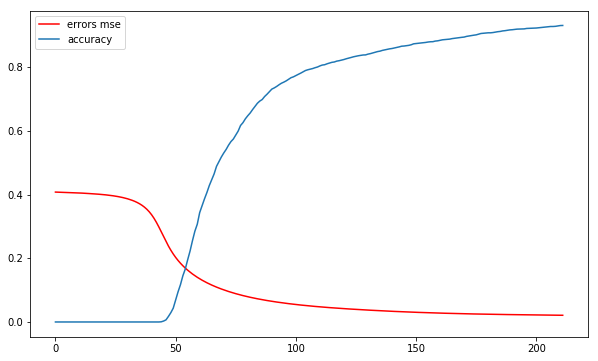

In [23]:

plt.figure(figsize = (10, 6))
plt.plot(errors, label='errors mse', color = 'red')
plt.plot(accuracy, label='accuracy')
plt.legend()
plt.show()

In [24]:
print("Error: %.4f, Accuracy: %.4f" % (min(errors), max(accuracy)))

Error: 0.0210, Accuracy: 0.9306


In [25]:

text_x = vectorizer.transform(df['text']).toarray()

print(text_x[0])

for i in range(20):  
    p = model.predict(text_x[i])  
   
    print("Predict: %.2f, Actual: %.2f, Class: %s, \n %s" % (p, df['target'][i], df['class'][i], df['text'][i])) 
    print('')

[0. 0. 0. ... 0. 0. 0.]
Predict: 0.01, Actual: 0.00, Class: ham , 
  Go until jurong point  crazy Available only in bugis n great world la e buffet Cine there got amore wat

Predict: 0.01, Actual: 0.00, Class: ham , 
  Ok lar Joking wif u oni

Predict: 0.99, Actual: 1.00, Class: spam, 
   Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 Text FA to 87121 to receive entry questionstd txt rateTCs apply 08452810075over18s

Predict: 0.00, Actual: 0.00, Class: ham , 
  U dun say so early hor U c already then say

Predict: 0.00, Actual: 0.00, Class: ham , 
  Nah I dont think he goes to usf  he lives around here though

Predict: 0.86, Actual: 1.00, Class: spam, 
   FreeMsg Hey there darling its been 3 weeks now and no word back Id like some fun you up for it still Tb ok XxX std chgs to send  150 to rcv

Predict: 0.00, Actual: 0.00, Class: ham , 
  Even my brother is not like to speak with me They treat me like aids patent

Predict: 0.05, Actual: 0.00, Class: ham , 
  As per y